In [1]:
import matplotlib.pyplot as plt
import re
from datetime import datetime

stat_dump_interval_s = 2

def plot_client_results(axs, xlim):
    # Define the file paths
    input_file_path = 'status_thread.txt'

    # Initialize a dictionary to hold the data
    client_data = {}

    # Compile the regular expressions for matching lines
    client_regex = re.compile(r'client(\d+) stats:')
    
    # data_regex = re.compile(r'.*(\d+) operations; \[(READ|UPDATE): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
    data_regex = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*operations; \[(READ|UPDATE|INSERT): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()
    
    start_time = None
    
    # Open and read the input file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            client_match = client_regex.match(line)
            if client_match:
                client_id = client_match.group(1)
                # Check if the next line contains the data
                if i + 1 < len(lines):
                    data_match = data_regex.match(lines[i + 1])
                    if data_match:
                        # Extract the relevant data
                        timestamp_str, _, count, avg, p99, p999 = data_match.group(1, 2, 3, 4, 5, 6)
                        timestamp_s = timestamp_to_seconds(timestamp_str)
                        if start_time is None:
                            start_time = timestamp_s

                        # Check if the client ID already exists in the dictionary
                        if client_id not in client_data:
                            client_data[client_id] = {'Tput': [], 'Avg': [], '99': [], '999': [], 'ts': []}
                        # Append the data to the lists in the dictionary
                        client_data[client_id]['Tput'].append(int(count)*16*1024/(1024*1024)/stat_dump_interval_s)
                        client_data[client_id]['Avg'].append(float(avg)/1000)
                        client_data[client_id]['99'].append(float(p99)/1000)
                        client_data[client_id]['999'].append(float(p999)/1000)
                        client_data[client_id]['ts'].append(timestamp_s)
    


    def plot_metric(metric, title, ylabel, fig_loc):
        plt.figure(figsize=(8, 5))
        for client_id, stats in client_data.items():
            # time_points = [stat_dump_interval_s * i for i in range(len(stats[metric]))]
            # time_points = client_data[client_id]['ts']
            time_points = [ts - start_time for ts in client_data[client_id]['ts']]
            if metric == 'Count':
                data_points = [x for x in stats[metric]]
            else:
                data_points = [x for x in stats[metric]]
            axs[fig_loc[0]].plot(time_points, data_points, marker='o', label=f'Client {client_id}')
        
        if metric == 'Tput':
            client_tput_avgs = []
            client_tput_sums = []
            client_tput_len = min([len(client_data[client_id]['Tput']) for client_id in client_data])
            for i in range(client_tput_len):
                client_tput_sum = sum([client_data[client_id]['Tput'][i] for client_id in client_data])
                client_tput_sums.append(client_tput_sum)
                client_tpu_avg = client_tput_sum / len(client_data)
                client_tput_avgs.append(client_tpu_avg)
            # time_points = [stat_dump_interval_s * i for i in range(client_tput_len)]
            time_points = [ts - start_time for ts in client_data[client_id]['ts']]
            if len(time_points) > len(client_tput_avgs):
                time_points = time_points[:(len(client_tput_avgs)-len(time_points))]
            axs[fig_loc[0]].plot(time_points, client_tput_avgs, marker='o', label='Average', color='black')
            axs[fig_loc[0]].plot(time_points, client_tput_sums, marker='o', label='Sum')

        axs[fig_loc[0]].set_title(title)
        axs[fig_loc[0]].set_xlabel('Time (s)')
        axs[fig_loc[0]].set_xlim(xlim)
        axs[fig_loc[0]].set_ylabel(ylabel)
        axs[fig_loc[0]].legend()
        axs[fig_loc[0]].grid(True)
        # axs[fig_loc[0], fig_loc[1]].grid(True)

    # Plotting each metric
    plot_metric('Tput', 'Client Throughput', 'MB/s', (0, 0))
    plot_metric('Avg', 'Latency: Avg', '(ms)', (1, 0))
    plot_metric('99', 'Latency: 99p', '99th Percentile (ms)', (2, 0))

    return start_time


In [2]:
import matplotlib.pyplot as plt
import re
import json
from datetime import datetime

def level2color(level):
    if level == 1:
        return "#fc9598"
    elif level == 2:
        return "#ff696e"
    elif level == 3:
        return "#f02225"
    elif level == 4:
        return "#cf1d20"
    elif level == 5:
        return "#ab1619"
    elif level == 6:
        return "#851114"
    else:
    # elif level == 7:
        return "#610c0e"

def plot_rocksdb_events(axs, experiment_start_time, xlim, fig_loc):
    log_file_path = '/mnt/tgriggs-disk/ycsb-rocksdb-data/LOG'
    flush_regex = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}) \d+ \[/flush_job\.cc:\d+\] \[default\] \[JOB \d+\] Flush: (\d+) microseconds, \d+ cpu microseconds, (\d+) bytes'
    )
    l0_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ level-0 files rate (\d+)')
    memtable_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ immutable memtables.*rate (\d+)')
    pending_compaction_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because of estimated pending compaction bytes \d+ rate (\d+)')

    compaction_regex = re.compile(r'.*EVENT_LOG_v1 (.*)$')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    def timestamp_to_micros(timestamp_str):
        timestamp_format = '%Y/%m/%d-%H:%M:%S.%f'
        dt = datetime.strptime(timestamp_str, timestamp_format)
        epoch = datetime(1970, 1, 1)
        micros_since_epoch = int((dt - epoch).total_seconds() * 1000000)
        return micros_since_epoch

    # Initialize lists for all events
    l0_stalls, memtable_stalls, pending_compaction_stalls, flush_data, compaction_data = [], [], [], [], []

    # Process the log file for stall, flush, and compaction events
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # L0 and Memtable Stalls
            l0_match = l0_stall_pattern.search(line)
            if l0_match:
                timestamp_str, rate = l0_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                l0_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_match = memtable_stall_pattern.search(line)
            if memtable_match:
                timestamp_str, rate = memtable_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            pending_compact_match = pending_compaction_stall_pattern.search(line)
            if pending_compact_match:
                timestamp_str, rate = pending_compact_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                pending_compaction_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            # Flush Events
            flush_match = flush_regex.match(line)
            if flush_match:
                timestamp_str, flush_microseconds, flush_bytes = flush_match.groups()
                start_time_seconds = timestamp_to_seconds(timestamp_str) - int(flush_microseconds) / 1e6
                rate_MB_s = (int(flush_bytes) / int(flush_microseconds)) * 1e6 / (1024**2)
                flush_data.append((start_time_seconds, rate_MB_s, int(flush_microseconds)/1e6))
            
            # Compaction Events
            compaction_match = compaction_regex.match(line)
            if compaction_match:
                json_str = compaction_match.group(1)
                try:
                    event_data = json.loads(json_str)
                    if event_data['event'] != 'compaction_finished':
                        continue
                    end_time_seconds = event_data['time_micros'] / 1e6
                    start_time_seconds = end_time_seconds - event_data['compaction_time_micros'] / 1e6
                    # start_time_seconds = event_data['time_micros'] / 1e6
                    # end_time_seconds = start_time_seconds + event_data['compaction_time_micros'] / 1e6
                    read_rate = event_data['read_rate']
                    write_rate = event_data['write_rate']
                    output_level = event_data['output_level']
                    compaction_data.append((start_time_seconds, end_time_seconds, read_rate, write_rate, output_level))
                except:
                    print("Compaction json error")

    # Determine the overall start time
    all_start_times = [d[0] for d in flush_data + compaction_data + l0_stalls + memtable_stalls]
    # experiment_start_time = min(all_start_times)
    internal_start_time = min(all_start_times)
    print(internal_start_time)
    print(experiment_start_time)

    # Convert L0 and Memtable timestamps to seconds since experiment start
    l0_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in l0_stalls]
    l0_rates = [int(rate) for _, rate in l0_stalls]

    memtable_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in memtable_stalls]
    memtable_rates = [int(rate) for _, rate in memtable_stalls]

    pending_compaction_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in pending_compaction_stalls]
    pending_compaction_rates = [int(rate) for _, rate in pending_compaction_stalls]

    # Plotting
    # plt.figure(figsize=(8, 5))

    # Plot L0 and Memtable Stalls
    axs[fig_loc[0]].scatter(l0_timestamps, l0_rates, label='L0 Stalls', color='blue', s=10)
    axs[fig_loc[0]].scatter(memtable_timestamps, memtable_rates, label='Memtable Stalls', color='purple', s=10)
    axs[fig_loc[0]].scatter(pending_compaction_timestamps, pending_compaction_rates, label='Pend Compact Stalls', color='orange', s=10)

    # Plot Flush Events
    for start_time, rate, duration in flush_data:
        axs[fig_loc[0]].hlines(rate, start_time - experiment_start_time, (start_time + duration) - experiment_start_time, colors='green', linewidth=2, label='Flush' if flush_data.index((start_time, rate, duration)) == 0 else "")

    # Plot Compaction Events
    for start_time, end_time, read_rate, write_rate, output_level in compaction_data:
        color = level2color(output_level)
        axs[fig_loc[0]].hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label='Compaction' if compaction_data.index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
        # axs[fig_loc[0]].hlines(read_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label='Compaction Read' if compaction_data.index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
        # axs[fig_loc[0]].hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors=color, linewidth=2, label='Compaction Write' if compaction_data.index((start_time, end_time, read_rate, write_rate, output_level)) == 0 else "")
    
    axs[fig_loc[0]].set_title('Database Operations Over Time')
    axs[fig_loc[0]].set_xlabel('Time (seconds since start of experiment)')
    axs[fig_loc[0]].set_ylabel('MB/s')
    axs[fig_loc[0]].set_xlim(xlim)
    # axs[fig_loc[0]].set_ylim(0, 400)
    axs[fig_loc[0]].legend()
    axs[fig_loc[0]].grid(True)
    # plt.show()

In [3]:
# Overall throughputs (client + system)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import time

def timestamp_to_seconds(timestamp_str):
  timestamp = datetime.strptime(timestamp_str.rstrip(), '%Y-%m-%d %H:%M:%S.%f')
  epoch = datetime(1970, 1, 1)
  return (timestamp - epoch).total_seconds()

def plot_overall_tputs(axs, start_time, xlim, fig_loc):
  df_from_csv = pd.read_csv("iostat_results.csv")

  # print(f"Timestamp: {timestamp_to_seconds(df_from_csv['Timestamp'][0])}")

  # Use the same approach to plot, ignoring the actual timestamps
  time_seconds = np.arange(len(df_from_csv))

  # Plotting
  # axs[fig_loc[0]].figure(figsize=(10, 6))
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["rMB/s"], label='Read MB/s', marker='o')
  axs[fig_loc[0]].plot(time_seconds, df_from_csv["wMB/s"], label='Write MB/s', marker='o')

  axs[fig_loc[0]].set_title('SSD Throughput Over Time')
  axs[fig_loc[0]].set_xlabel('Time (s)')
  axs[fig_loc[0]].set_ylabel('MB/s')
  axs[fig_loc[0]].set_xlim(xlim)
  # axs[fig_loc[0]].set_ylim(0,16)
  axs[fig_loc[0]].legend(loc='right')
  axs[fig_loc[0]].grid(True)

  # Creating a second y-axis
  ax2 = axs[fig_loc[0]].twinx()
  # Plotting on the secondary y-axis
  ax2.plot(time_seconds, df_from_csv["rMB/s"]/700, label='Read Util', marker='x', linestyle='--', color='tab:blue')
  ax2.plot(time_seconds, df_from_csv["wMB/s"]/420, label='Write Util', marker='+', linestyle='--', color='tab:orange')
  ax2.set_ylabel('Utilization (based on tput)')
  ax2.legend(loc='upper right')
  ax2.set_ylim(0,1)

  # Adjust the right margin to accommodate the second y-axis legend
  plt.subplots_adjust(right=0.85)

  # Show plot
  # plt.show()


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def plot_cpu_util(axs, start_time, xlim, fig_loc):
    df = pd.read_csv("mpstat_results.csv")
    
    # Assuming core values are strings and stripping any potential whitespace
    df['core'] = df['core'].map(lambda x: x.strip())
    df_filtered = df[df['core'].isin(['0', '1', '2', '3', '4', '5', '6', '7', '8'])].copy()

    # Convert metrics to float
    df_filtered['usr'] = df_filtered['usr'].map(lambda x: float(x))
    df_filtered['sys'] = df_filtered['sys'].map(lambda x: float(x))
    df_filtered['iowait'] = df_filtered['iowait'].map(lambda x: float(x))
    df_filtered['soft'] = df_filtered['soft'].map(lambda x: float(x))
    df_filtered['idle'] = df_filtered['idle'].map(lambda x: float(x))

    # Calculate the sum of iowait and idle for each row
    df_filtered['sum_iowait_idle'] = df_filtered['iowait'] + df_filtered['idle']
    
    # For plotting purposes, assuming each row represents a sequential time unit
    time_seconds = np.arange(len(df_filtered))

    # Group by core and plot each group
    for core, group in df_filtered.groupby('core'):
        # Calculate the index for each group based on its length
        group_index = np.arange(len(group))
        axs[fig_loc[0]].plot(group_index, [100 - x for x in group['sum_iowait_idle']], label=f'Core {core} idle+iowait')

    axs[fig_loc[0]].set_title('CPU Utilization (all but iowait and idle)')
    axs[fig_loc[0]].set_xlabel('Time (seconds)')
    axs[fig_loc[0]].legend(loc='upper right')
    axs[fig_loc[0]].grid(True)
    axs[fig_loc[0]].set_xlim(xlim)
    axs[fig_loc[0]].set_ylim(-2, 102)


1712158594.938495
1712158557.0


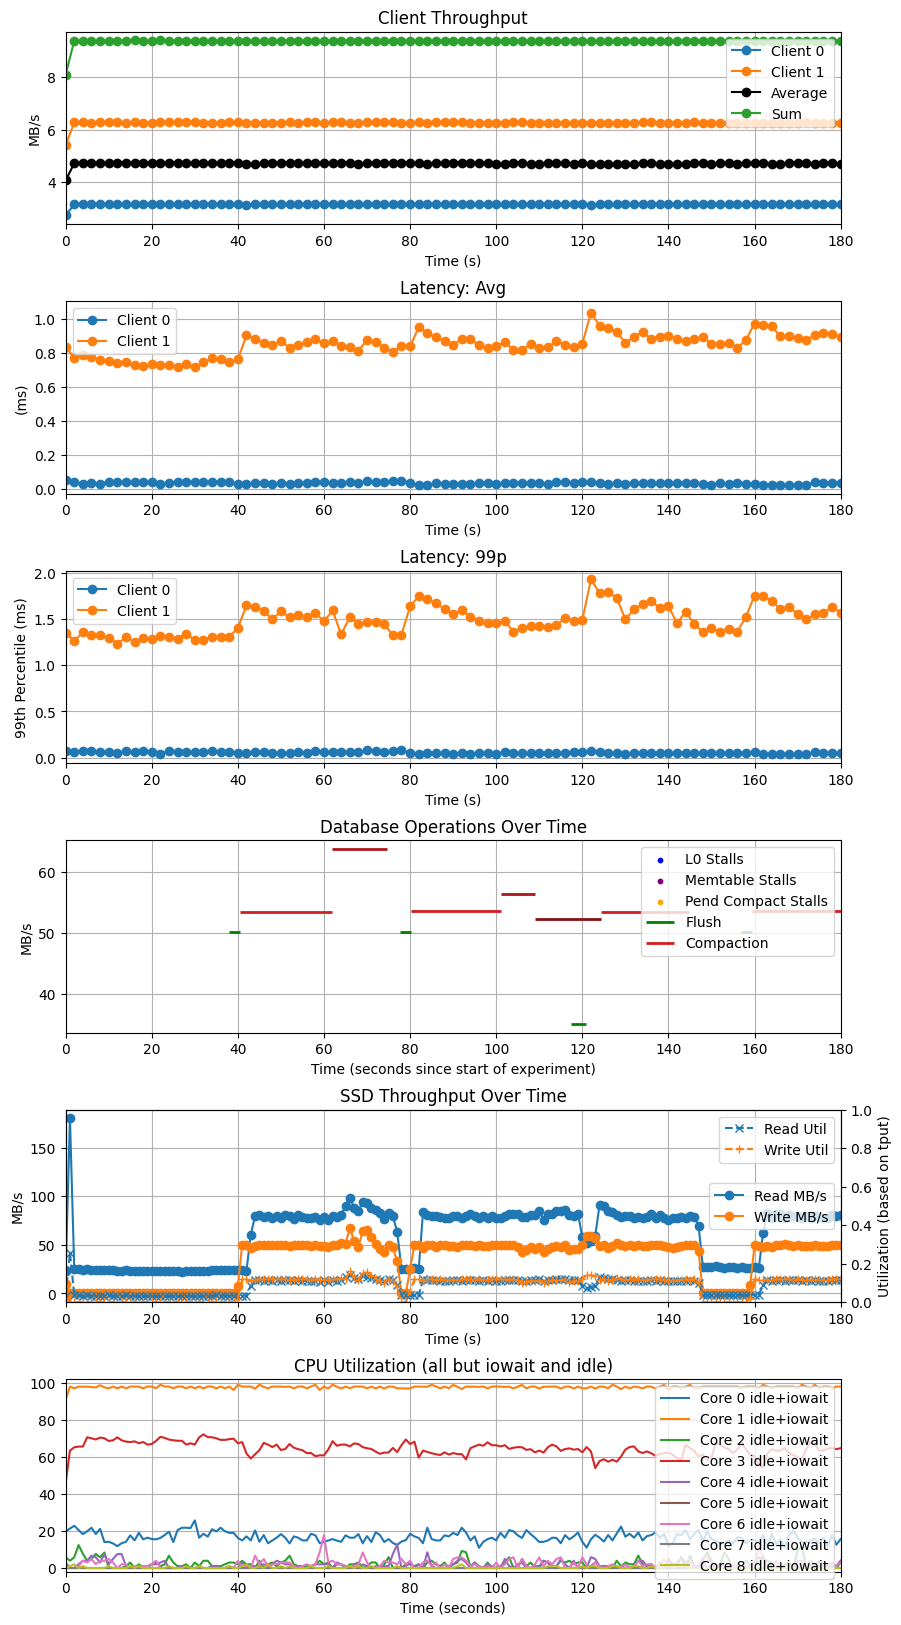

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

In [13]:
def generate_plots(xlim):
  fig, axs = plt.subplots(6, 1, figsize=(10, 20))
  plt.subplots_adjust(hspace=0.4)
  start_time = plot_client_results(axs, xlim)
  plot_rocksdb_events(axs, start_time, xlim, (3,0))
  plot_overall_tputs(axs, start_time, xlim, (4,0))
  plot_cpu_util(axs, start_time, xlim, (5,0))
  plt.show()

xlim = (0, 180)
generate_plots(xlim)

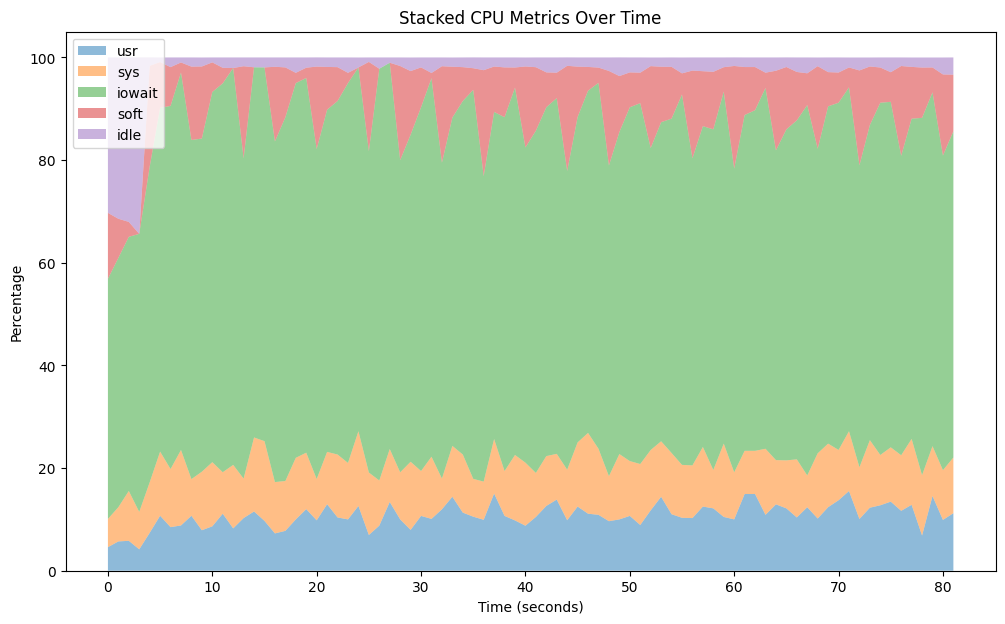

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the CSV file is named 'cpu_data.csv'
csv_file_path = 'mpstat_results.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

df['core'] = df['core'].map(lambda x: x.strip().rstrip())
df_filtered = df[df['core'].isin(['0', '1', '2', '3'])].copy()

df_filtered['usr'] = df_filtered['usr'].map(lambda x: float(x))
df_filtered['sys'] = df_filtered['sys'].map(lambda x: float(x))
df_filtered['iowait'] = df_filtered['iowait'].map(lambda x: float(x))
df_filtered['soft'] = df_filtered['soft'].map(lambda x: float(x))
df_filtered['idle'] = df_filtered['idle'].map(lambda x: float(x))

columns_to_stack = ['usr', 'sys', 'iowait', 'soft', 'idle']
stacked_values = df_filtered[columns_to_stack].cumsum(axis=1)

# Time or X-axis values, assuming each row is 1 second apart as mentioned earlier
time = range(len(df_filtered))

data_series = [df_filtered['usr'], df_filtered['sys'], df_filtered['iowait'], df_filtered['soft'], df_filtered['idle']]

plt.figure(figsize=(12, 7))

# Using stackplot to plot and fill the area under each series
plt.stackplot(time, data_series, labels=['usr', 'sys', 'iowait', 'soft', 'idle'], alpha=0.5)

plt.title('Stacked CPU Metrics Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Percentage')
plt.legend(loc='upper left')

plt.show()
